### Exercise 8.3

Modify the 2D model with variable viscosity (Exercise 7.2) by including the advection of
density and viscosity fields with markers. Use a 500 × 500 km2 model with 51 × 51 grid and
free slip boundaries. Initial model geometry corresponds to the mantle (η = 1021 Pa s, ρ =
3300 kg/m3) with a central circular plume of 100 km radius (η = 1020 Pa s, ρ = 3200 kg/m3).
Create a grid of 200 × 200 markers (i.e., 4 × 4 markers per cell) with small (up to 1/2 of the
marker grid distance) random displacements (rand) relative to regular positions

In [46]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy import sparse
import scipy.sparse.linalg

### Step 1: setup the mesh

In [47]:
# Numerical model parameters
g = 10.0  # grav acc
eta0 = 1e20 # viscosity for non-dimensionalization
# mesh
xsize = 500000.0 # Model size, m
ysize = 750000.0
xnum = 31   # Number of nodes
ynum = 46
xstp = xsize/(xnum-1) # Grid step
ystp = ysize/(ynum-1)
xs = np.linspace(0.0, xsize, xnum) # construct xs 
ys = np.linspace(0.0, ysize, ynum) # construct ys


# functions for indexing
def get_node_index(iy, jx):
    '''
    todo
    '''
    inode = jx * (ynum + 1) + iy
    return inode
    
def get_indexed_on_node(inode):
    '''
    todo
    '''
    ivx = 3 * inode
    ivy = 3 * inode + 1
    ip = 3 * inode + 2
    return ivx, ivy, ip

    
# nondimensionalization
Kcont = 2 * eta0 / (xstp + ystp)

### Step 2: Material model

In [48]:
def get_density(x, y):
    '''
    Return value of density with coordinates
    '''
    if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
        if (x < xsize/2.0):
            rho = 3200.0
        else:
            rho = 3300.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
        assert(x.shape == y.shape)
        rho = np.ones(x.shape) * 3300.0
        mask = (x < xsize/2.0)
        rho[mask] = 3200.0
    else:
        raise TypeError("Type of x and y should be float or np.ndarray")
    return rho


def get_viscosity(x, y):
    '''
    Return value of viscosity with coordinates, for variable viscosities.
    '''
    eta_l = 1e20
    eta_r = 1e22
    if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
        if (x < xsize/2.0):
            eta = eta_l
        else:
            eta = eta_r
    elif type(x) == np.ndarray and type(y) == np.ndarray:
        assert(x.shape == y.shape)
        eta = np.ones(x.shape) * eta_l
        mask = (x < xsize/2.0)
        eta[mask] = eta_r
    else:
        raise TypeError("Type of x and y should be float or np.ndarray")
    return eta


def get_viscosity_at_P(iy, jx):
    '''
    return the viscosity defined at the P node of a cell
    '''
    x = xs[jx]  # viscosity at this node
    y = ys[iy]
    eta = get_viscosity(x, y)
    xUL = xs[jx-1]  # at the node to the upper left
    yUL = ys[iy-1]
    etaUL = get_viscosity(xUL, yUL)
    xA = xs[jx] # at the node above
    yA = ys[iy-1]
    etaA = get_viscosity(xA, yA)
    xL = xs[jx-1]  # at the node to the left
    yL = ys[iy]
    etaL = get_viscosity(xL, yL)
    eta1 = average(eta, etaUL, etaA, etaL, method='harmonic')
    return eta1


def average(*vars, **kwargs):
    '''
    average vars by the method given
    '''
    method = kwargs.get('method', 'arithmatic')
    aver = 0
    if method == "arithmatic":
        n = 0
        for var in vars:
            aver += var
            n += 1
        aver = aver/n
    elif method == "harmonic":
        n = 0
        for var in vars:
            assert(np.abs(var) > 1e-16)
            aver += 1.0 / var
            n += 1
        aver = n / aver
    else:
        raise TypeError("Method must be arithmatic or harmonic")
    return aver

Step 3: Construct the matrix and the solution

$in_{node}$ is the indexing of nodes, increasing first along the y direction (i), then the x direction (j).

$in_{vx}$, $in_{vy}$, $in_{P}$ are the indexes of velocity and pressure in the vector of solution, respectively.

$in_{node} = (j_x-1)\times(N_y-1)+i_y$ (as in matlib)

$in_{node} = j_x \times (N_y-1)+i_y+1$ (as in python)

$ in_{vx} = 3 \times in_{node} - 2 $

$ in_{vy} = 3 \times in_{node} - 1 $

$ in_{P} = 3 \times in_{node}$

In [49]:
def checkL(L, R, j):
    '''
    check L along column j
    '''
    print("\n")
    print("Looking for entry of column %d" % j)
    I, J, V= sparse.find(L)
    mask = (J == j)
    for k in range(I.size):
        if mask[k]:
            i = I[k]
            print("%d th row of L: " % i)
            mask1 = (I == i)
            print("column in row %d:\n" % i, J[mask1])
            print("values in row %d:\n" % i, V[mask1])
            print("%d th entry in R: " % i)
            print(R[i])

In [50]:
class STOKES_CONTINUITY():
    '''
    Attributes:

    '''
    def __init__(self, xnum, ynum):
        '''
        initialization
        '''
        self.xnum = xnum
        self.ynum = ynum
        self.N = 3 * (xnum + 1) * (ynum + 1)  # number of the unknown, 3 (vx, vy, P) * number of node.
        self.L = None # the left matrix
        self.R = None # the right matrix
        self.dofs = {} # degree of freedom

    def assemble(self):
        I = []
        J = []
        V = []
        R = np.zeros(self.N)
        k = 0

        # nondimensionalization
        # get_viscosity_at_P
        Kcont = 2 * eta0 / (xstp + ystp)
        scale = eta0 / xstp ** 2.0 # use this to scale the entry
        scale1 = Kcont / xstp

        # fill in internal cells
        # loop for points, first along y axis, then along x axis.
        # Incement on k to fill in entries in each row in the L matrix,
        # as well as the R vector
        nStokes_x = 0
        nStokes_y = 0
        nContinuity = 0
        nBdVx = 0
        nBdVy = 0
        nGhost = 0
        for jx in range(xnum+1):
            for iy in range(ynum+1):
                # value of x and y
                x = jx * xstp
                y = iy * ystp
                inode0 = get_node_index(iy, jx)
                inodeA = get_node_index(iy-1, jx)
                inodeB = get_node_index(iy+1, jx)
                inodeL = get_node_index(iy, jx-1)
                inodeR = get_node_index(iy, jx+1)
                inodeUR = get_node_index(iy-1, jx+1)
                inodeBL = get_node_index(iy+1, jx-1)
                if iy > 0 and iy < ynum and jx > 0 and jx < xnum-1:      
                    # x-Stokes equation
                    ivx1, _, _ = get_indexed_on_node(inodeL)
                    ivx2, ivy1, _ = get_indexed_on_node(inodeA)
                    ivx3, ivy2, ip1 = get_indexed_on_node(inode0)
                    ivx4, _, _ = get_indexed_on_node(inodeB)
                    ivx5, ivy4, ip2 = get_indexed_on_node(inodeR)
                    _, ivy3, _ = get_indexed_on_node(inodeUR)
                    eta = get_viscosity_at_P(iy, jx)  # get viscosity
                    etaA = get_viscosity_at_P(iy-1, jx)
                    etaR = get_viscosity_at_P(iy, jx+1)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(2.0 * eta / xstp ** 2.0 / scale)
                    I.append(k)  # vx node above
                    J.append(ivx2)
                    # V.append(eta / ystp ** 2.0 / scale)
                    V.append(etaA / ystp ** 2.0 / scale)
                    I.append(k)  # vx node
                    J.append(ivx3)
                    # V.append(- 2.0 * eta * (1 / xstp**2.0 + 1 / ystp**2.0) / scale)
                    V.append((- 2.0 * etaR / xstp**2.0 - 2.0 * eta / xstp**2.0\
                        - eta / ystp**2.0 - etaA / ystp**2.0)/ scale)
                    I.append(k)  # vx node below
                    J.append(ivx4)
                    V.append(eta / ystp ** 2.0 / scale)
                    I.append(k) # vx node to the right
                    J.append(ivx5)
                    # V.append(eta / xstp ** 2.0 / scale)
                    V.append(2.0 * etaR / xstp ** 2.0 / scale)
                    I.append(k) # vy node above
                    J.append(ivy1)
                    V.append(etaA / xstp / ystp / scale)
                    I.append(k) # vy node
                    J.append(ivy2)
                    V.append(-eta / xstp / ystp / scale)
                    I.append(k) # vy node to the upper right
                    J.append(ivy3)
                    V.append(-etaA / xstp / ystp / scale)
                    I.append(k) # vy node to the right
                    J.append(ivy4)
                    V.append(eta / xstp/ ystp/ scale)
                    I.append(k)  # P node
                    J.append(ip1)
                    V.append(Kcont / xstp / scale)
                    I.append(k) # P node to the right
                    J.append(ip2)
                    V.append(-Kcont / xstp / scale)
                    R[k] = 0
                    k += 1
                    nStokes_x += 1
                if iy > 0 and iy < ynum-1 and jx > 0 and jx < xnum:
                    # y-Stokes equation
                    ivx1, ivy1, _ = get_indexed_on_node(inodeL)
                    _, ivy2, _ = get_indexed_on_node(inodeA)
                    ivx3, ivy3, ip1 = get_indexed_on_node(inode0)
                    ivx4, ivy4, ip2 = get_indexed_on_node(inodeB)
                    _, ivy5, _ = get_indexed_on_node(inodeR)
                    ivx2, _, _ = get_indexed_on_node(inodeBL)
                    eta = get_viscosity_at_P(iy, jx)  # get viscosity
                    etaB = get_viscosity_at_P(iy+1, jx)
                    etaL = get_viscosity_at_P(iy, jx-1)
                    I.append(k) # vy node to the left
                    J.append(ivy1)
                    V.append(etaL / xstp ** 2.0 / scale)
                    I.append(k)  # vy node above
                    J.append(ivy2)
                    V.append(2.0 * eta / ystp ** 2.0 / scale)
                    I.append(k) # vy node
                    J.append(ivy3)
                    V.append((- 2.0 * etaB / ystp**2.0 - 2.0 * eta / ystp**2.0\
                        -eta / xstp**2.0 - etaL / xstp**2.0) / scale)
                    I.append(k)  # vy node below
                    J.append(ivy4)
                    V.append(2.0 * etaB / ystp ** 2.0 / scale)
                    I.append(k)  # vy node to the right
                    J.append(ivy5)
                    V.append(eta / xstp ** 2.0 / scale)
                    I.append(k) # vx node to the left
                    J.append(ivx1)
                    V.append(etaL / xstp / ystp / scale)
                    I.append(k) # vx node to the bottom-left
                    J.append(ivx2)
                    V.append(-etaL / xstp / ystp / scale)
                    I.append(k) # vx node
                    J.append(ivx3)
                    V.append(-eta / xstp / ystp / scale)
                    I.append(k) # vx node below
                    J.append(ivx4)
                    V.append(eta / xstp / ystp / scale)
                    I.append(k) # P node
                    J.append(ip1)
                    V.append(Kcont / ystp / scale)
                    I.append(k) # P node below
                    J.append(ip2)
                    V.append(-Kcont / ystp / scale)
                    R[k] = -g / 2.0 * (get_density(x-xstp, y) + get_density(x, y)) / scale
                    k += 1
                    nStokes_y += 1
                if iy > 0 and iy < ynum and jx > 0 and jx < xnum and not (iy == 1 and jx == 1):
                    # continuity equation
                    # note: check the last condition with others
                    ivx1, _, _ = get_indexed_on_node(inodeL)
                    _, ivy1, _ = get_indexed_on_node(inodeA)
                    ivx2, ivy2, _ = get_indexed_on_node(inode0)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(-Kcont / xstp / scale1)
                    I.append(k) # vx node
                    J.append(ivx2)
                    V.append(Kcont / xstp / scale1)
                    I.append(k) # vy node above
                    J.append(ivy1)
                    V.append(-Kcont / ystp / scale1)
                    I.append(k) # vy node
                    J.append(ivy2)
                    V.append(Kcont / ystp / scale1)
                    R[k] = 0 
                    k += 1
                    nContinuity += 1
                if iy not in [0, ynum] and jx in [0, xnum-1]:
                    # boudnary conditions by vx, normal
                    ivx, _, _ = get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivx)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nBdVx += 1
                if iy in [0, ynum-1] and jx != xnum:
                    # boudnary conditions by vx, tangential
                    ivx1, _, _ = get_indexed_on_node(inode0)
                    ivx2, _, _ = get_indexed_on_node(inodeB)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(1.0)
                    I.append(k)  # vx node
                    J.append(ivx2)
                    V.append(-1.0)
                    R[k] = 0
                    k += 1
                    nBdVx += 1
                if iy in [0, ynum-1] and jx not in [0, xnum]:
                    # boundary conditions by vy, normal
                    _, ivy, _ = get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivy)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nBdVy += 1
                if iy != ynum and jx in [0, xnum-1]:
                    # boundary conditions by vy, normal
                    _, ivy1, _ = get_indexed_on_node(inode0)
                    _, ivy2, _ = get_indexed_on_node(inodeR)
                    I.append(k)  # vy node
                    J.append(ivy1)
                    V.append(1.0)
                    I.append(k)  # vy node to the right
                    J.append(ivy2)
                    V.append(-1.0)
                    R[k] = 0
                    k += 1
                    nBdVy += 1
                if jx == xnum:
                    # ghost points for vx
                    ivx, _, _ = get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivx)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
                if iy == ynum:
                    # ghost points for vy
                    _, ivy, _ = get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivy)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
                if jx in [0, xnum] or iy in [0, ynum] or (iy == 1 and jx == 1):
                    # ghost points for P
                    # note:check last condition with people
                    _, _, ip = get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ip)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
        self.dofs['x stokes'] = nStokes_x
        self.dofs['y stokes'] = nStokes_y
        self.dofs['continuity'] = nContinuity
        self.dofs['bc Vx'] = nBdVx
        self.dofs['bc Vy'] = nBdVy
        self.dofs['ghost'] = nGhost
        self.dofs['total'] = k
        print(self.dofs)
        assert(k == self.N) # check we covered each row in the matrix
        self.L = sparse.csr_matrix((V, (I, J)), shape=(self.N, self.N))
        self.R = R

    def solve(self):
        '''
        Solver the linear equations
        '''
        self.S = scipy.sparse.linalg.spsolve(self.L, self.R)
        self.solved = True
# checkL(L, 18) # check for the coefficient of one node.


### Step 4: solve it

In [51]:
def parse_solution_P(S):
    '''
    parse the solution of P from S
    '''
    xx = np.zeros((xnum-1, ynum-1))
    yy = np.zeros((xnum-1, ynum-1))
    PP = np.zeros((xnum-1, ynum-1))
    for jx in range(1, xnum):
        for iy in range(1, ynum):
            # internal node
            inode0 = get_node_index(iy, jx)
            _, _, ip = get_indexed_on_node(inode0)
            x = (xs[jx] + xs[jx-1]) / 2.0
            y = (ys[iy] + ys[iy-1]) / 2.0
            xx[jx-1, iy-1] = x
            yy[jx-1, iy-1] = y
            PP[jx-1, iy-1] = S[ip] * Kcont
    return xx, yy, PP


def parse_solution_Vx(S):
    '''
    parse the solution of vx from S
    '''
    xx = np.zeros((xnum, ynum-1))
    yy = np.zeros((xnum, ynum-1))
    vvx = np.zeros((xnum, ynum-1))
    for jx in range(0, xnum):
        for iy in range(1, ynum):
            # internal node
            inode0 = get_node_index(iy, jx)
            ivx, _, _ = get_indexed_on_node(inode0)
            x = xs[jx]
            y = (ys[iy] + ys[iy-1]) / 2.0
            xx[jx, iy-1] = x
            yy[jx, iy-1] = y
            vvx[jx, iy-1] = S[ivx]
    return xx, yy, vvx   


def parse_solution_Vy(S):
    '''
    parse the solution of vy from S
    '''
    xx = np.zeros((xnum-1, ynum))
    yy = np.zeros((xnum-1, ynum))
    vvy = np.zeros((xnum-1, ynum))
    for jx in range(1, xnum):
        for iy in range(0, ynum):
            # internal node
            inode0 = get_node_index(iy, jx)
            _, ivy, _ = get_indexed_on_node(inode0)
            x = (xs[jx] + xs[jx-1]) / 2.0
            y = ys[iy]
            xx[jx-1, iy] = x
            yy[jx-1, iy] = y
            vvy[jx-1, iy] = S[ivy]
    return xx, yy, vvy

In [52]:
# assemble the matrix
Solver = STOKES_CONTINUITY(xnum, ynum)
Solver.assemble()

{'x stokes': 1305, 'y stokes': 1320, 'continuity': 1349, 'bc Vx': 152, 'bc Vy': 152, 'ghost': 234, 'total': 4512}


In [53]:
# solve
Solver.solve()

/tmp/ipykernel_2943309/4202920517.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


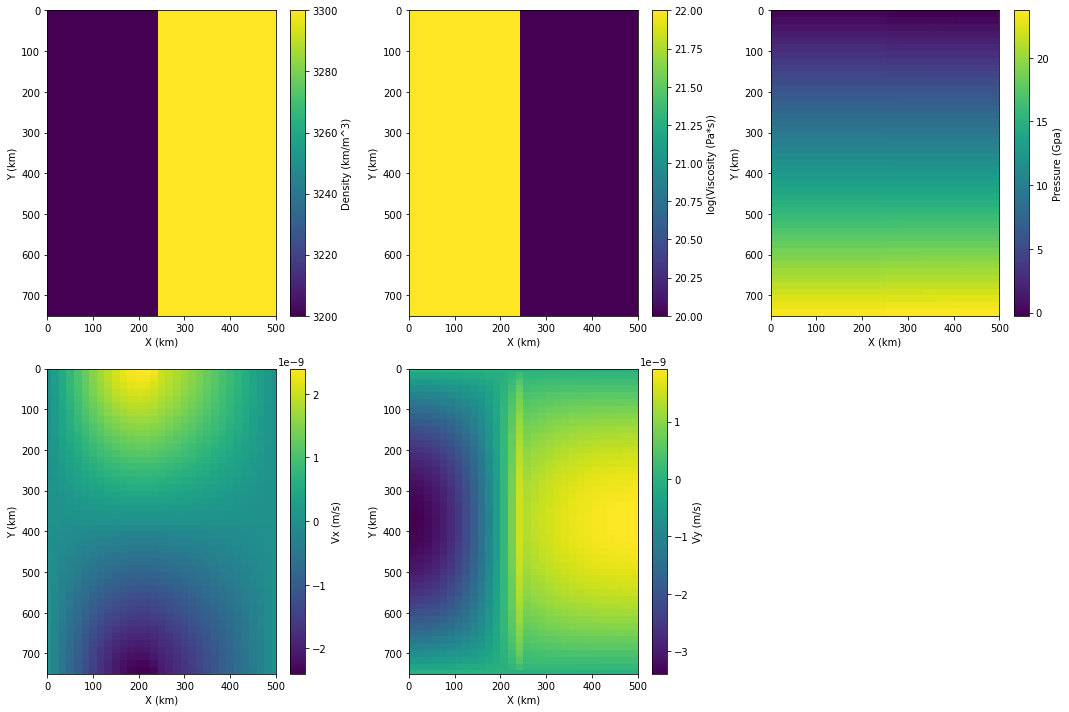

In [54]:
# generate mesh outputs
xx, yy = np.meshgrid(xs, ys)
rhorho = get_density(xx, yy)
etaeta = get_viscosity(xx, yy)
xxp, yyp, pp = parse_solution_P(Solver.S)
xx_vx, yy_vx, vvx = parse_solution_Vx(Solver.S)
xx_vy, yy_vy, vvy = parse_solution_Vy(Solver.S)
# plot
fig = plt.figure(tight_layout=True, figsize=(15, 10))
gs = gridspec.GridSpec(2, 3)
ax = fig.add_subplot(gs[0, 0])  # density
h=ax.pcolormesh(xx/1e3, yy/1e3, rhorho)
ax.set_xlim([0.0, xsize/1e3])
ax.set_ylim([0.0, ysize/1e3])
ax.set_xlabel('X (km)') 
ax.set_ylabel('Y (km)')
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='Density (km/m^3)')
ax = fig.add_subplot(gs[0, 1]) # viscosity
h=ax.pcolormesh(xx/1e3, yy/1e3, np.log10(etaeta))
ax.set_xlim([0.0, xsize/1e3])
ax.set_ylim([0.0, ysize/1e3])
ax.set_xlabel('X (km)') 
ax.set_ylabel('Y (km)')
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='log(Viscosity (Pa*s))')
ax = fig.add_subplot(gs[0, 2]) # pressure
h=ax.pcolormesh(xxp/1e3, yyp/1e3, pp/1e9)
ax.set_xlim([0.0, xsize/1e3])
ax.set_ylim([0.0, ysize/1e3])
ax.set_xlabel('X (km)') 
ax.set_ylabel('Y (km)')
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='Pressure (Gpa)')
ax = fig.add_subplot(gs[1, 0]) # vx
h=ax.pcolormesh(xx_vx/1e3, yy_vx/1e3, vvx)
ax.set_xlim([0.0, xsize/1e3])
ax.set_ylim([0.0, ysize/1e3])
ax.set_xlabel('X (km)') 
ax.set_ylabel('Y (km)')
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='Vx (m/s)')
ax = fig.add_subplot(gs[1, 1])
h=ax.pcolormesh(xx_vy/1e3, yy_vy/1e3, vvy)
ax.set_xlim([0.0, xsize/1e3])
ax.set_ylim([0.0, ysize/1e3])
ax.set_xlabel('X (km)') 
ax.set_ylabel('Y (km)')
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='Vy (m/s)')
fig.show()